# QUEST Datathon 2021<a class="anchor" id="top"></a>
## Hack Islamophobia

Varun Singhai, Asher Gilani, Daniel Ben-Or<br>


## Table of Contents

1. [Introduction](#Introduction) <br>
2. [Data Wrangling](#2) <br>
    2.1 [Imports](#2.1) <br>
    2.2 [Loading in the Data](#2.2) <br>
    2.3 [Tidy Data](#2.3) <br>
3. [Data Exploration](#3) <br>
    3.1 [Plotting](#3.1) <br>
    3.2 [Verified Users](#3.2) <br>
    3.3 [Retweet Distribution](#3.3) <br>
    3.4 [Time Distribution of Tweets](#3.4) <br>
    3.5 [Initial Conclusions](#3.5) <br>
4. [Word Cloud](#4) <br>
5. [Penetration Network](#5) <br>
    5.1 [Generating Mentions Column](#5.1) <br>
    5.2 [Aggregating Users + Preparing Network](#5.2)<br>
    5.3 [Creating Network](#5.3) <br>
6. [Sentiment Analysis](#6) <br>
    6.1 [Sentiment Intensity Column](#6.1) <br>
    6.2 [Showcase Best/Worse Tweets](#6.2) <br>
    6.3 [Plotting Sentiment Distribution](#6.3) <br>
7. [Hashtag Bar Chart Race](#7) <br>
    7.1 [Distribution of tweets](#7.1) <br>
    7.2 [Video](#7.2) <br>
8. [Live Tweet Flagging](#8)<br>
    8.1 [Classification](#8.1)<br>
    8.2 [Live Tweets](#8.2) <br>
9. [Twitter Heatmap](#9)<br>
    9.1 [Dot Map](#9.1)<br>
    9.2 [Heat Map](#9.2)<br>
10. [Conclusion](#10) <br>

<a id=Introduction></a>
## 1. Introduction

<a id=2></a>
## 2. Data Wrangling

I want to figure out where Islamaphobic tweets are originating from (which tweets, users, etc) as well as what factors contribute to responses to these tweets.

The given dataset comes with  a lot of excess columns so I will try to extract the relevant data.

<a id=2.1></a>
### 2.1 Imports

In [2]:
import pandas as pd
import statsmodels as sm
from collections import defaultdict, Counter
import json

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import seaborn as sns; sns.set()

import networkx as nx
from pyvis.network import Network

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('punkt'); nltk.download('stopwords')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud

import datetime
from tqdm import tqdm
import bar_chart_race as bcr

import folium
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap

ModuleNotFoundError: No module named 'statsmodels'

<a id=2.2></a>
### 2.2 Loading in the Data

In [3]:
df_50k = pd.read_csv('./noislamophobia-dataset-50k.csv')
df_75k = pd.read_csv('./noislamophobia-dataset-75k.csv')
df = pd.concat([df_50k,df_75k])
df.head()

,_id,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,...,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,full_text,truncated,user,withheld_in_countries
0,ObjectId(59dbede4e6e465a2d67a1062),NaN,NaN,Sun Oct 22 10:34:06 +0000 2017,"{""hashtags"":[{""text"":""BanIslam"",""indices"":[93,...",NaN,0,False,NaN,9.220484e+17,...,NaN,4,False,"{""created_at"":""Fri Oct 20 09:33:45 +0000 2017""...","<a href=""http://twitter.com/download/iphone"" r...",RT @Private34349909: @AmyMek @Dab7One 1/ @real...,NaN,False,"{""id"":8.009259051368776e+17,""id_str"":""80092590...",NaN
1,ObjectId(59dbede4e6e465a2d67a106c),NaN,NaN,Sun Oct 22 10:13:40 +0000 2017,"{""hashtags"":[{""text"":""muslim"",""indices"":[16,23...",NaN,0,False,NaN,9.220433e+17,...,NaN,10,False,"{""created_at"":""Sat Oct 21 18:37:07 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @ensine: All #muslim rulers were savages bc...,NaN,False,"{""id"":375089876,""id_str"":""375089876"",""name"":""द...",NaN
2,ObjectId(59dbf266e6e465a2d67a4810),NaN,NaN,Sun Oct 22 07:50:47 +0000 2017,"{""hashtags"":[{""text"":""Raqqa"",""indices"":[37,43]...",NaN,0,False,NaN,9.220073e+17,...,NaN,172,False,"{""created_at"":""Fri Oct 20 23:15:45 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @SLandinSoCal: Liberated Women of #Raqqa‼️R...,NaN,False,"{""id"":7.092975641898926e+17,""id_str"":""70929756...",NaN
3,ObjectId(59dbf266e6e465a2d67a4828),NaN,NaN,Sun Oct 22 10:38:23 +0000 2017,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{...",NaN,0,False,NaN,9.220495e+17,...,NaN,1,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@Stormtroepen @cdavandaag @sybrandbuma @gertja...,NaN,True,"{""id"":1340408646,""id_str"":""1340408646"",""name"":...",NaN
4,ObjectId(59e8e630e6e465a2d6238c9c),NaN,NaN,Sun Oct 22 08:59:53 +0000 2017,"{""hashtags"":[{""text"":""RT"",""indices"":[51,54]},{...",NaN,0,False,NaN,9.220247e+17,...,NaN,25,False,"{""created_at"":""Sun Oct 22 01:40:55 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @PoliticalIslam: Sharia at odds with Articl...,NaN,False,"{""id"":150595824,""id_str"":""150595824"",""name"":""🇮...","[""DE""]"


In [5]:
df.in_reply_to_screen_name.notna().sum()

7262

<a id=2.3></a>
### 2.3 Tidy Data

In [6]:
# Get a username column
df.user[0]

'{"id":8.009259051368776e+17,"id_str":"800925905136877569","name":"Cl_USARocks 🇺🇸","screen_name":"usarocks_c","location":"United States","description":"Grateful 4 Trump fam! Support Trump 100%! Thank U Vets, Police, BP \\u0026 All Who Protect Us!🙏🏻 I stand!🇺🇸 #MAGA🚫NFL 🚫Islam 🚫Sharia Law 🚫No Flirt DM’s👈🏻","url":"https://t.co/LiQOFDfZgS","entities":{"url":{"urls":[{"url":"https://t.co/LiQOFDfZgS","expanded_url":"http://www.Happily.Married.2.Vet","display_url":"Happily.Married.2.Vet","indices":[0,23]}]},"description":{"urls":[]}},"protected":false,"followers_count":10789,"friends_count":10761,"listed_count":21,"created_at":"Tue Nov 22 04:56:31 +0000 2016","favourites_count":21130,"utc_offset":null,"time_zone":null,"geo_enabled":false,"verified":false,"statuses_count":14405,"lang":"en","contributors_enabled":false,"is_translator":false,"is_translation_enabled":false,"profile_background_color":"F5F8FA","profile_background_image_url":null,"profile_background_image_url_https":null,"profile_b

In [7]:
origin = df[['user', 'in_reply_to_screen_name', 'retweet_count', 'retweeted', 'created_at', 'text']]
origin.head()

,user,in_reply_to_screen_name,retweet_count,retweeted,created_at,text
0,"{""id"":8.009259051368776e+17,""id_str"":""80092590...",NaN,4,False,Sun Oct 22 10:34:06 +0000 2017,RT @Private34349909: @AmyMek @Dab7One 1/ @real...
1,"{""id"":42565769,""id_str"":""42565769"",""name"":""Epi...",NaN,9,False,Sun Oct 22 08:50:43 +0000 2017,RT @PoliticalIslam: Educate yourself! #RT http...
2,"{""id"":1461022464,""id_str"":""1461022464"",""name"":...",NaN,0,False,Sun Oct 22 10:28:09 +0000 2017,"Say, @CanadianPM @JustinTrudeau @liberal_party..."
3,"{""id"":142379064,""id_str"":""142379064"",""name"":""ॐ...",NaN,3,False,Sun Oct 22 10:12:59 +0000 2017,RT @ensine: Another reason KHANgressi govt mus...
4,"{""id"":8.88537147011158e+17,""id_str"":""888537147...",NathanHensley19,0,False,Sun Oct 22 10:35:20 +0000 2017,@NathanHensley19 @davidholman82 @barry206 @Sky...


In [8]:
# want to get username, user_id_str, followers_count, verified out of 'user'
user_df = origin.user.apply(json.loads).apply(pd.Series)
user_df.head()

,id,id_str,name,screen_name,location,description,url,entities,protected,followers_count,...,profile_text_color,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,following,follow_request_sent,notifications,translator_type,withheld_in_countries
0,8.009259e+17,800925905136877569,Cl_USARocks 🇺🇸,usarocks_c,United States,Grateful 4 Trump fam! Support Trump 100%! Than...,https://t.co/LiQOFDfZgS,{'url': {'urls': [{'url': 'https://t.co/LiQOFD...,False,10789,...,333333,True,False,True,False,False,False,False,none,NaN
1,4.256577e+07,42565769,Epicurist,Demontialto,Australia,"Atheist, Free thinker hopefully. RT not necess...",None,{'description': {'urls': []}},False,623,...,000000,False,False,False,False,False,False,False,none,NaN
2,1.461022e+09,1461022464,Steers Mann,SteersMann,"BC, Canada",Retired electronics technologist; proponent of...,None,{'description': {'urls': [{'url': 'https://t.c...,False,787,...,333333,True,False,True,False,False,False,False,none,NaN
3,1.423791e+08,142379064,ॐ भारत ॐ,_dharam_vir,हिन्दू राष्ट्र भारत,धृति: क्षमा दमोऽस्‍तेयं शौचमिन्‍द्रियनिग्रह: ।...,https://t.co/P8k1D0FqWN,{'url': {'urls': [{'url': 'https://t.co/P8k1D0...,False,21211,...,333333,True,False,False,False,False,False,False,none,NaN
4,8.885371e+17,888537147011158017,Guy Fawkes,Anonymo95592895,,,None,{'description': {'urls': []}},False,29,...,333333,True,False,True,False,False,False,False,none,NaN


In [10]:
origin['id_str'] = user_df.id_str
origin['username'] = user_df.screen_name
origin['followers_count'] = user_df.followers_count
origin['verified'] = user_df.verified
origin = origin[['username', 'id_str', 'followers_count', 'verified', 'in_reply_to_screen_name', 'retweet_count', 'retweeted', 'text', 'created_at']]
origin.head()

,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at
0,usarocks_c,800925905136877569,10789,False,NaN,4,False,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,Sun Oct 22 10:34:06 +0000 2017
1,Demontialto,42565769,623,False,NaN,9,False,RT @PoliticalIslam: Educate yourself! #RT http...,Sun Oct 22 08:50:43 +0000 2017
2,SteersMann,1461022464,787,False,NaN,0,False,"Say, @CanadianPM @JustinTrudeau @liberal_party...",Sun Oct 22 10:28:09 +0000 2017
3,_dharam_vir,142379064,21211,False,NaN,3,False,RT @ensine: Another reason KHANgressi govt mus...,Sun Oct 22 10:12:59 +0000 2017
4,Anonymo95592895,888537147011158017,29,False,NathanHensley19,0,False,@NathanHensley19 @davidholman82 @barry206 @Sky...,Sun Oct 22 10:35:20 +0000 2017


In [11]:
# The retweeted column is always false, so recalculate it
origin.retweeted = origin.text.str.startswith('RT')
print(f'Number of tweets that are RTs: {origin.retweeted.sum()}')

# created_at column is not of type datetime
origin.created_at = pd.to_datetime(origin.created_at)

origin[origin.retweeted].head()

Number of tweets that are RTs: 57505


,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at
0,usarocks_c,800925905136877569,10789,False,NaN,4,True,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,2017-10-22 10:34:06+00:00
1,Demontialto,42565769,623,False,NaN,9,True,RT @PoliticalIslam: Educate yourself! #RT http...,2017-10-22 08:50:43+00:00
3,_dharam_vir,142379064,21211,False,NaN,3,True,RT @ensine: Another reason KHANgressi govt mus...,2017-10-22 10:12:59+00:00
5,IFoundThatThis,2835196635,12,False,NaN,46,True,RT @Anni_Cyrus: 963 under 10 yr child brides i...,2017-10-22 08:11:44+00:00
6,SithJeep,2180717723,1143,False,NaN,46,True,RT @Anni_Cyrus: 963 under 10 yr child brides i...,2017-10-22 10:20:06+00:00


<a id=3></a>
## 3. Data Exploration
I now have the dataframe origin which has the username and some potential measures for how popular the user is and how much "penetration potential" their tweets have.

Will now begin to explore the data.

<a id=3.1></a>
### 3.1 Plotting

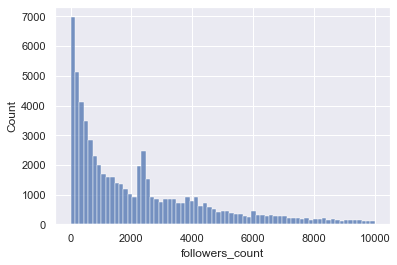

In [12]:
sns.histplot(data=origin, x='followers_count', binrange=(0, 10000))

<a id=3.2></a>
### 3.2 Verified Users

In [ ]:
origin[origin.verified].head()

<a id=3.3></a>
### 3.3 Retweet Distribution

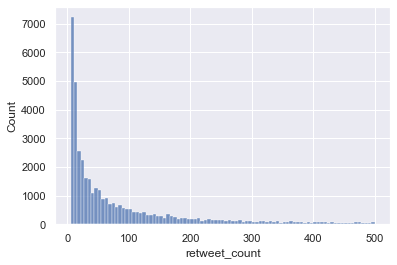

In [14]:
# I excludes tweets with < 5 retweets since they are a clear majority and mess up the scale of the graph
sns.histplot(data=origin, x='retweet_count', binrange=(5, 500))

<a id=3.4></a>
### 3.4 Time Distribution of Tweets

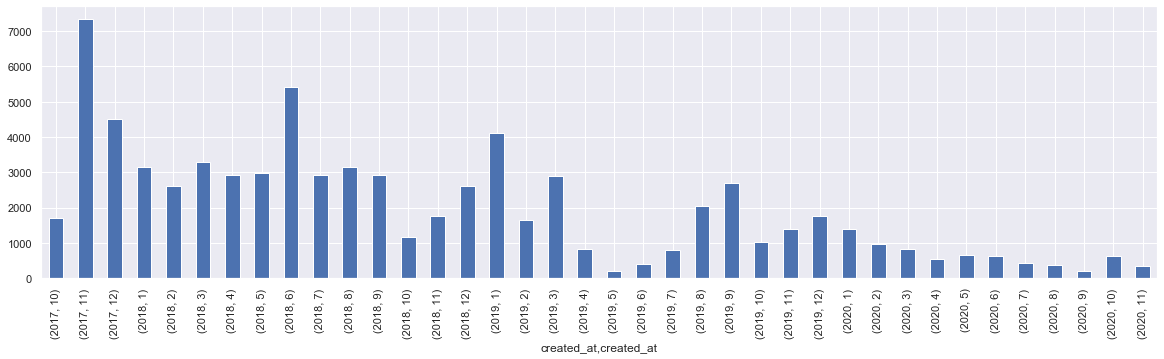

In [15]:
origin.groupby([origin.created_at.dt.year, origin.created_at.dt.month])['username'].count().plot(kind='bar', figsize=(20, 5))

<a id=3.5></a>
### 3.5 Initial Conclusions
- Most of the people tweeting in this dataset have very few followers. The distribution of followers is highest at 0 with an exponential dropoff for larger amounts of followers.
- There are very few verified users (around 28). These users obviously have a high amount of followers compared to other users.
- These verified users are retweeted a lot. The retweet_count distribution has an exponential dropoff and all of these verified users have retweet_counts much higher than shown in the retweet_count histogram.
- Verified users also retweet others a lot. This was not properly indicated in the retweeted column, so I recalculated it.
- Most of our tweets come from late 2017 - 2018 with fewer tweets in 2019 and 2020. November 2017 had a particularly high amount of tweets. Likely due to [this attempted bombing](https://en.m.wikipedia.org/wiki/2017_New_York_City_attempted_bombing).

<a id=4></a>
## 4 Word Cloud
Show which words are the most popular to get a general idea of what people are tweeting about.

In [16]:
# Filter out words that start with things in filter_list or any stopwords
filter_list = ['@', '#', 'http', 'rt', '&', 'islam', 'muslim', 'religion', 'don', 'need', 'know']
stops = set(stopwords.words('english'))

def good_wd(wd):
    return not any(wd.lower().startswith(x) for x in filter_list) and wd not in stops

# Clean up tweets
tweets = df.text.dropna().str.split().apply(lambda lst: ' '.join(filter(good_wd, lst)))

# Generate word cloud
wordcloud = WordCloud().generate(' '.join(tweets))
image = wordcloud.to_image()
#image.save('wordcloud.png')

![wordcloud](./wordcloud.png)

<a id=5></a>
## 5. Penetration Network
At this point, it seems clear that verified users have much higher Twitter penetration since they are much more involved in the process of retweeting as well as being retweeted. There are not many verified users in this dataset so I will also be looking at users with a high amount of followers. I will try to visualize how tweets from these users spread and what factors influence this spread.

<a id=5.1></a>
### 5.1 Generating Mentions Column

In [17]:
# Get a column that has all the @'d users for that tweet
origin['mentions'] = origin.text.str.split().apply(lambda lst: [(x[1:-1] if x.endswith(':') else x[1:]) for x in filter(lambda x: x.startswith('@'), lst)])
origin.head()

,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at,mentions
0,usarocks_c,800925905136877569,10789,False,NaN,4,True,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,2017-10-22 10:34:06+00:00,"[Private34349909, AmyMek, Dab7One, realDonaldT..."
1,Demontialto,42565769,623,False,NaN,9,True,RT @PoliticalIslam: Educate yourself! #RT http...,2017-10-22 08:50:43+00:00,"[PoliticalIslam, PoliticalIslam]"
2,SteersMann,1461022464,787,False,NaN,0,False,"Say, @CanadianPM @JustinTrudeau @liberal_party...",2017-10-22 10:28:09+00:00,"[CanadianPM, JustinTrudeau, liberal_party,]"
3,_dharam_vir,142379064,21211,False,NaN,3,True,RT @ensine: Another reason KHANgressi govt mus...,2017-10-22 10:12:59+00:00,[ensine]
4,Anonymo95592895,888537147011158017,29,False,NathanHensley19,0,False,@NathanHensley19 @davidholman82 @barry206 @Sky...,2017-10-22 10:35:20+00:00,"[NathanHensley19, davidholman82, barry206, Sky..."


<a id=5.2></a>
### 5.2 Aggregating Users + Preparing Network

In [18]:
cols = ['username', 'followers_count', 'retweet_count', 'mentions']

# Aggregate users to count their average num of followers, total retweets, and total mentions
graph_df = origin[cols].groupby('username').agg({'followers_count': 'mean', 'retweet_count': 'sum', 'mentions': 'sum'}).reset_index()

# Will use follower count to represent node size; scale them between sizes [1000, 51000] for the network
graph_df['scaled_count'] = 1000 + (graph_df.followers_count - graph_df.followers_count.min()) * 50000 / (graph_df.followers_count.max() - graph_df.followers_count.min())

# Explode df on mentions to add in edges
graph_df = graph_df.explode('mentions')

# Add underscore to usernames and mentions so they aren't treated as ints by the library
graph_df.username = graph_df.username + '_'
graph_df.mentions = graph_df.mentions + '_'

# Calculate hex color codes so that higher retweet count corresponds to darker red node
norm = Normalize(vmin=0, vmax=5000, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Reds)
graph_df['colors'] = graph_df.retweet_count.apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))

graph_df.head()

,username,followers_count,retweet_count,mentions,scaled_count,colors
0,0000DD02_,3000.0,3,76rooster_,1203.042204,#fff5f0
1,000_Gopal32_,2410.0,215,Donotshit_,1163.110570,#ffeee6
2,001Nationalist_,60.0,2,NaN,1004.060844,#fff5f0
3,001_rhonda_,994.0,508,yeatsfeats_,1067.274650,#fee4d8
3,001_rhonda_,994.0,508,JoeBelsha1_,1067.274650,#fee4d8


<a id=5.3></a>
### 5.3 Creating Network

In [19]:
# More red = More retweets, Larger = More followers
nodes = graph_df.head(500).drop_duplicates('username')
mentions = [x for x in graph_df.head(500).mentions.dropna() if x not in nodes.username]
title_col = 'Followers: ' + nodes.followers_count.astype(int).astype(str) + '\nRetweets: ' + nodes.retweet_count.astype(str)

nt = Network(height=800, width='100%', notebook=True, directed=True)
nt.add_nodes(nodes.username.to_numpy(), title=title_col, value=nodes.scaled_count, color=nodes.colors)
nt.add_nodes(mentions, title=mentions, value=[50] * len(mentions), color=['#FFFFFF'] * len(mentions))
nt.add_edges(graph_df[['username', 'mentions']].head(500).dropna().to_records(index=False))

nt.show('pen_network.html')

<a id=6></a>
## 6. Sentiment Analysis
I will be using the VADER Sentiment Analysis library since it works well on emojis and slang. This library also uses NLTK under the hood for parsing out stop words. This will generate a score for each tweet from -1 to 1.
- Score < -0.05: Negative Sentiment
- Score > 0.05: Positive Sentiment
- -0.05 <= Score <= 0.05: Neutral Sentiment

<a id=6.1></a>
### 6.1 Sentiment Intensity Column

In [21]:
sent = SentimentIntensityAnalyzer()
origin['sentiment'] = origin.text.apply(lambda s: sent.polarity_scores(s)['compound'])
origin.head()

,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at,mentions,sentiment
0,usarocks_c,800925905136877569,10789,False,NaN,4,True,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,2017-10-22 10:34:06+00:00,"[Private34349909, AmyMek, Dab7One, realDonaldT...",0.4648
1,Demontialto,42565769,623,False,NaN,9,True,RT @PoliticalIslam: Educate yourself! #RT http...,2017-10-22 08:50:43+00:00,"[PoliticalIslam, PoliticalIslam]",0.0000
2,SteersMann,1461022464,787,False,NaN,0,False,"Say, @CanadianPM @JustinTrudeau @liberal_party...",2017-10-22 10:28:09+00:00,"[CanadianPM, JustinTrudeau, liberal_party,]",0.0000
3,_dharam_vir,142379064,21211,False,NaN,3,True,RT @ensine: Another reason KHANgressi govt mus...,2017-10-22 10:12:59+00:00,[ensine],0.0000
4,Anonymo95592895,888537147011158017,29,False,NathanHensley19,0,False,@NathanHensley19 @davidholman82 @barry206 @Sky...,2017-10-22 10:35:20+00:00,"[NathanHensley19, davidholman82, barry206, Sky...",-0.8922


<a id=6.2></a>
### 6.2 Showcase Best/Worse Tweets

In [22]:
# Five worst sentiment tweets
list(origin.sort_values('sentiment').text[:5])

['@potus WE HAVE A #terrorism problem \nAmerica will NEVER submit to 🚫#Islam \n😠😠😠😠😠😠😠😠😠😠😠 @ICEgov @SecretService @FBI… https://t.co/LTzitgKuJk',
 '#Sweden :  #Girl #gang #raped , #VAGINA SET ON #FIRE 😠😠😠😠😠😠😠😠\n#EnoughIsEnough \nSTOP #rapeculture\nSTOP #CARNAGE… https://t.co/Lax7gOkkze',
 'RT @Chris_A10_USA: #Ireland 🇮🇪: #Muslim #migrant charged in random #stabbing #murder, Gardai still say no link to #terrorism 😠😠😠😠😠\n#BanShar…',
 'RT @Greeneyz0080: @IlhanMN Forgot these, cupcake. You’re welcome.\n#BanIslam #islamistheproblem\n👿👿👿👿👿👿👿👿👿 https://t.co/4IwIZzwwuD',
 '@IlhanMN Forgot these, cupcake. You’re welcome.\n#BanIslam #islamistheproblem\n👿👿👿👿👿👿👿👿👿 https://t.co/4IwIZzwwuD']

In [23]:
# Five best sentiment tweets
list(origin.sort_values('sentiment', ascending=False).text[:5])

['Goodnight friends \n🇳🇱🇳🇱🇳🇱🇳🇱🇳🇱🇳🇱🇳🇱\n♥️♥️♥️♥️♥️♥️♥️\n🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸\n♥️♥️♥️♥️♥️♥️♥️\n#Trump \n#TrumpLandslide2020… https://t.co/w7k752m9Dj',
 'RT @BoondockCat: @WindowFixed @Ilhan 🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣\nWhere are all the moderates\nwhen you need them!\n\nMuslim women, children, &amp; gays\nbeing raped…',
 '@BreitbartNews @shash1026 😂😂😂😂😂😂😂😂😂😂😂. Oh no, we don’ t biatch,  YOU ALONE ARE RESPONSIBLE FOR THEM BEING IN CONGRE… https://t.co/CzAgZzWYOC',
 'RT @mineisC: @BreitbartNews @shash1026 😂😂😂😂😂😂😂😂😂😂😂. Oh no, we don’ t biatch,  YOU ALONE ARE RESPONSIBLE FOR THEM BEING IN CONGRESS. YOU OWE…',
 '@matloobshah11 @Whiskey100Proof @TeamTrump @realDonaldTrump @thebbtcenter Honors and respects women? 😂😂😂😂😂😂😂😂😂 That… https://t.co/CnvzuUs1Dw']

In [24]:
# Five tweets with most neutral sentiment
list(origin.sort_values('sentiment', key=abs).text[:5])

['RT @Chris_A10_USA: 🇬🇧 #UK : #Muslim rams car into crowded nightclub, injuring 13 partygoers 😳😳😳\n#StopCarnage #ReligionOfPeace #Bansharia #B…',
 '@RajatSharmaLive So simple sir \nCoz #IslamIsTheProblem',
 'RT @Ru260566: #BanIslam https://t.co/Z4pTXrB7uI',
 'Again, Tell me why we should let them into America ! #BANSHARIA #EndDACA https://t.co/DEDYUZkIog https://t.co/emonDesiW5',
 'RT @UKInfidel: #IslamExposed: #Rapejihad in #Cambridge: Muslim Walks out of Court: https://t.co/6rEm1P9XVY\n\n#UK #Britain🇬🇧\n\n#Sunnah of #Ras…']

<a id=6.3></a>
### 6.3 Plotting Sentiment Distribution

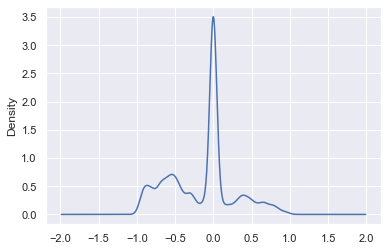

In [25]:
origin.sentiment.plot.kde()

This sentiment analysis is not perfect. It definitely does a better job detecting meaner tweets, but it seems to rely heavily on the type of emojis used since the top five all have angry emojis. The highest sentiment tweets are still quite Islamaphobic, but this is to be expected since this dataset primarily includes Islamaphobic tweets. Looking at the KDE plot of sentiment distribution, most tweets have been tagged with neutral sentiment. There is a higher peak of negative tweets in comparison to positive tweets which is a good sanity check.

<a id=7></a>
## 7. Hashtag Bar Chart Race

This type of visualization helps with trends over time. We can see what trends there are amongst the hashtags, whether that is popularity, distribution over time, as well as overall cumulation of the hashtags. 

In [5]:
df_50k = pd.read_csv('../noislamophobia-dataset-50k.csv')
df_75k = pd.read_csv('../noislamophobia-dataset-75k.csv')
df = pd.concat([df_50k,df_75k])
df.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (2,8,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,_id,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,...,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,full_text,truncated,user,withheld_in_countries
0,ObjectId(59dbede4e6e465a2d67a1062),NaN,NaN,Sun Oct 22 10:34:06 +0000 2017,"{""hashtags"":[{""text"":""BanIslam"",""indices"":[93,...",NaN,0,False,NaN,9.220484e+17,...,NaN,4,False,"{""created_at"":""Fri Oct 20 09:33:45 +0000 2017""...","<a href=""http://twitter.com/download/iphone"" r...",RT @Private34349909: @AmyMek @Dab7One 1/ @real...,NaN,False,"{""id"":8.009259051368776e+17,""id_str"":""80092590...",NaN
1,ObjectId(59dbede4e6e465a2d67a106c),NaN,NaN,Sun Oct 22 10:13:40 +0000 2017,"{""hashtags"":[{""text"":""muslim"",""indices"":[16,23...",NaN,0,False,NaN,9.220433e+17,...,NaN,10,False,"{""created_at"":""Sat Oct 21 18:37:07 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @ensine: All #muslim rulers were savages bc...,NaN,False,"{""id"":375089876,""id_str"":""375089876"",""name"":""द...",NaN
2,ObjectId(59dbf266e6e465a2d67a4810),NaN,NaN,Sun Oct 22 07:50:47 +0000 2017,"{""hashtags"":[{""text"":""Raqqa"",""indices"":[37,43]...",NaN,0,False,NaN,9.220073e+17,...,NaN,172,False,"{""created_at"":""Fri Oct 20 23:15:45 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @SLandinSoCal: Liberated Women of #Raqqa‼️R...,NaN,False,"{""id"":7.092975641898926e+17,""id_str"":""70929756...",NaN
3,ObjectId(59dbf266e6e465a2d67a4828),NaN,NaN,Sun Oct 22 10:38:23 +0000 2017,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{...",NaN,0,False,NaN,9.220495e+17,...,NaN,1,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@Stormtroepen @cdavandaag @sybrandbuma @gertja...,NaN,True,"{""id"":1340408646,""id_str"":""1340408646"",""name"":...",NaN
4,ObjectId(59e8e630e6e465a2d6238c9c),NaN,NaN,Sun Oct 22 08:59:53 +0000 2017,"{""hashtags"":[{""text"":""RT"",""indices"":[51,54]},{...",NaN,0,False,NaN,9.220247e+17,...,NaN,25,False,"{""created_at"":""Sun Oct 22 01:40:55 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @PoliticalIslam: Sharia at odds with Articl...,NaN,False,"{""id"":150595824,""id_str"":""150595824"",""name"":""🇮...","[""DE""]"


In [6]:
df = df.drop_duplicates()
df_na = df.dropna(axis=1, thresh=.75)

In [7]:
table = defaultdict(int)

for entity in df['entities']:
    test = json.loads(entity)
    for x in test['hashtags']:
            table[x['text'].lower()] += 1

We want to create an index in the dataframe that is solely dates for the library to run against.

In [8]:
df_datetime = pd.to_datetime(df['created_at']).dt.date
df_datetime.head()

0    2017-10-22
1    2017-10-22
2    2017-10-22
3    2017-10-22
4    2017-10-22
Name: created_at, dtype: object

<a id=7.1></a>
### 7.1 Distribution of Tweets

Through this distribution, we can see an overall downward trend in islamaphobic tweets, where spikes are correlated with terrorist attacks that have muslim backgrounds (such as ISIS). For example, in November of 2017, the highest influx of islamophobic tweets occured after the terrorist car attack that happened in New York City. 

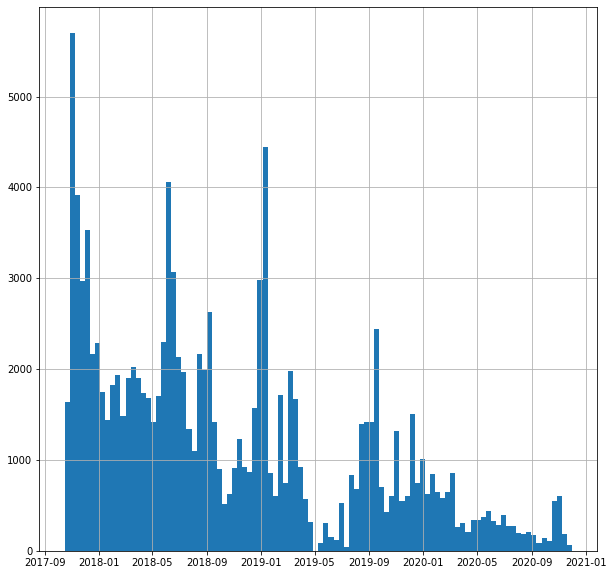

In [22]:
df_datetime.hist(figsize=(10,10), bins=100)
plt.show()

In [23]:
table = dict(sorted(table.items(), key=lambda item: item[1], reverse=True))
Counter(table).most_common(10)

[('banislam', 28780),
 ('bansharia', 13500),
 ('islamistheproblem', 8704),
 ('islamexposed', 6135),
 ('bansharialaw', 4006),
 ('stopislam', 2660),
 ('rapejihad', 1096),
 ('nosharia', 1051),
 ('sharialaw', 908),
 ('billwarnerphd', 838)]

Create a new dataframe for the bar chart race with an index created on the date and the `entities` column as one of the columns in the dataframe, that holds the hashtags in them

In [24]:
new_df = df.copy()
new_df['date'] = pd.to_datetime(new_df['created_at']).dt.date
new_df.index = new_df['date']
new_df = new_df[['entities']]
new_df.head()

,entities
date,
2017-10-22,"{""hashtags"":[{""text"":""BanIslam"",""indices"":[93,..."
2017-10-22,"{""hashtags"":[{""text"":""muslim"",""indices"":[16,23..."
2017-10-22,"{""hashtags"":[{""text"":""Raqqa"",""indices"":[37,43]..."
2017-10-22,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
2017-10-22,"{""hashtags"":[{""text"":""RT"",""indices"":[51,54]},{..."


In [16]:
datetime_dict = defaultdict(lambda: defaultdict(dict))

def get_counts(entity):
    table = defaultdict(int)
    test = json.loads(entity)
    for x in test['hashtags']:
        table[x['text'].lower()] += 1
    return table
    

for idx, row in tqdm(new_df.iterrows()):
    datetime_dict[idx] = dict(Counter(datetime_dict[idx]) + Counter(get_counts(row['entities'])))

119019it [00:16, 7201.81it/s]


<a id=7.2></a>
### 7.2 Video

The bar chart race video shows some pretty revealing revelations. Most of the islamophobic sentiments have the hashtag #banIslam in them, while as the rest of the hashtags seems to influx as time goes on. Furthermore, another pattern is how the frequency of the tweets start to slow down as time goes on, showing that twitter seems to be hampering down on racial charge tweets as time goes on.

In [11]:
# df_bar_chart_race = pd.DataFrame.from_dict(datetime_dict,orient='index').fillna(value=0).cumsum()
# bcr.bar_chart_race(df = df_bar_chart_race.head(), 
#                    n_bars=5, 
#                    title = "Popular Hashtags (2017-2021)", 
#                    period_length=250,
#                    bar_kwargs={'alpha': .7},
#                    bar_label_size=7)

<video controls src="hashtag_bcr.mp4" />

<a id=8></a>
## 8. Live Tweet Flagging

This classification model is in the beginning phases, but through simply passing in the most popular hashtags found in the 2 datasets given to us, I am able to flag tweets in live time (or upto a given date), and it is very evident that racially charged tweets are still very prevelant in our society. Through some more NLP on the classification, I hope to flag down tweets at a higher and more efficient rate than the flagging I am doing right now. This live flagging is simply a tool to monitor all the analysis we have provided above that help identify the problem. 

<a id=8.1></a>
### 8.1 Classification

In [17]:
import twint
# grab the hashtags we want to track
table = defaultdict(int)

for entity in df['entities']:
    test = json.loads(entity)
    for x in test['hashtags']:
            table[x['text'].lower()] += 1

table = Counter(table)
table = dict(table.most_common(100))

# Remove hashtags that won't hold relevance in flagging
remove  = ['islam', 'muslim', 'religionofpeace', 'uk', 'maga', 'britain', 'muslims', 'buildthewall', 'jihad', 'americafirst', 'religionbeliefs', 'patriotic', 'america', 'wakeupamerica', 'islamic', 'rt', 'stopcarnage', 'pvv', 'kag', 'breaking', 'makedclisten', 'christian',
'educateyourselfonislam', 'tcot', 'terror','freetommy', 'allah', 'migrant', 'usa', 'trump2020', 'travelban', 'us', 'freetommyrobinson', 'rape', 'immigrationreform', 'bannogozones', 'france', 'lilbulli', 'germany','draintheswamp', 'canada', 'europe','cspi','pakistan','trump','veterans', 'trumptrain', 'iran', 'bancair','ramadan', 'closernation','walkaway', 'tocatchathief', 'minnesota', 'wwg1wga', 'potus', 'hamas', 'quran', 'trudeaumustgo', 'murder','ovc16', 'sweden', 'christians',
'police', 'israel', 'isis']
[table.pop(key) for key in remove]
Counter(table).most_common(15)

[('banislam', 28780),
 ('bansharia', 13500),
 ('islamistheproblem', 8704),
 ('islamexposed', 6135),
 ('bansharialaw', 4006),
 ('stopislam', 2660),
 ('rapejihad', 1096),
 ('nosharia', 1051),
 ('sharialaw', 908),
 ('billwarnerphd', 838),
 ('sharia', 827),
 ('cair', 814),
 ('islamicstate', 801),
 ('endislam', 716),
 ('qanon', 651)]

In [18]:
string = " OR ".join(list(table.keys())[:10])
print(string)

banislam OR bansharia OR islamistheproblem OR islamexposed OR bansharialaw OR stopislam OR rapejihad OR nosharia OR sharialaw OR billwarnerphd


<a id=8.2></a>
### 8.2 Live Tweets

Notice how recent these tweets are, through some further digging, I was able to get the location of some of the users, creating a hypothesis that some of these users may be bots with the minimal amount of data associated with the username.

In [20]:
c = twint.Config()

# Configure
c = twint.Config()
c.Search = string
# c.Username = 'sckasturi'
c.Since = "2021-02-13"
c.Limit = 100
# c.Location = True
c.Store_csv = True
# c.Output = "twitter2.csv"

# Run
# twint.run.Search(c)


In [21]:
df_twitter = pd.read_csv('./twitter2.csv')
df_twitter.head()

# import datetime
counter = 0
for index, row in (df_twitter.iterrows()):
    if df_twitter['date'][index] == "2021-02-19" and counter  <20:
        print(df_twitter['created_at'][index] + ' ' + df_twitter['username'][index] + ': ' + df_twitter['tweet'][index] + '\n')
        counter += 1

2021-02-19 20:19:48 EST chrisishere9: @tagesthemen @HadijaHaruna Es gibt noch viel zu tun, damit #Breitscheidplatz sich nicht wiederholt. #StopIslam

2021-02-19 19:39:18 EST frontsocial: @Suliv16 @F_Desouche C'est ça, prenez nous pour des cons !😏  #Erdogan : "Les mosquées sont nos casernes, les coupoles nos casques, les minarets nos baïonnettes et les croyants nos soldats"  #Grandremplacement #migrants #DefendEurope #Remigration #StopIslam #FrontSocial #RIC   https://t.co/l6VV2qJ4QD  https://t.co/HY2P50T7Pf

2021-02-19 17:42:22 EST nelsonlahaya: @umarebru @NUnl @NUnl geen enkele normaal denkende Nederlandse vrouw laat zich onderdrukken door zo'n doek om haar hoofd te knopen. Laat staan dat ze ermee van de zon gaan genieten.  Is  https://t.co/v49NUvjc3m geworden tot islam slaaf? Inderdaad om van te kotsen. #stopislam

2021-02-19 17:32:11 EST steam7r: #stopislam #STOPimmigration

2021-02-19 17:29:44 EST steam7r: #TurkeyIsATerrorState #TurkenTerreur #stopislam

2021-02-19 17:17:58 EST fro

<a id=9></a>
## 9. Twitter Heatmap

In [3]:
df_50k = pd.read_csv('noislamophobia-dataset-50k.csv')
df_75k = pd.read_csv('noislamophobia-dataset-75k.csv')
df = pd.concat([df_50k,df_75k])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,8,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,_id,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,...,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,full_text,truncated,user,withheld_in_countries
0,ObjectId(59dbede4e6e465a2d67a1062),NaN,NaN,Sun Oct 22 10:34:06 +0000 2017,"{""hashtags"":[{""text"":""BanIslam"",""indices"":[93,...",NaN,0,False,NaN,9.220484e+17,...,NaN,4,False,"{""created_at"":""Fri Oct 20 09:33:45 +0000 2017""...","<a href=""http://twitter.com/download/iphone"" r...",RT @Private34349909: @AmyMek @Dab7One 1/ @real...,NaN,False,"{""id"":8.009259051368776e+17,""id_str"":""80092590...",NaN
1,ObjectId(59dbede4e6e465a2d67a106c),NaN,NaN,Sun Oct 22 10:13:40 +0000 2017,"{""hashtags"":[{""text"":""muslim"",""indices"":[16,23...",NaN,0,False,NaN,9.220433e+17,...,NaN,10,False,"{""created_at"":""Sat Oct 21 18:37:07 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @ensine: All #muslim rulers were savages bc...,NaN,False,"{""id"":375089876,""id_str"":""375089876"",""name"":""द...",NaN
2,ObjectId(59dbf266e6e465a2d67a4810),NaN,NaN,Sun Oct 22 07:50:47 +0000 2017,"{""hashtags"":[{""text"":""Raqqa"",""indices"":[37,43]...",NaN,0,False,NaN,9.220073e+17,...,NaN,172,False,"{""created_at"":""Fri Oct 20 23:15:45 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @SLandinSoCal: Liberated Women of #Raqqa‼️R...,NaN,False,"{""id"":7.092975641898926e+17,""id_str"":""70929756...",NaN
3,ObjectId(59dbf266e6e465a2d67a4828),NaN,NaN,Sun Oct 22 10:38:23 +0000 2017,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{...",NaN,0,False,NaN,9.220495e+17,...,NaN,1,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@Stormtroepen @cdavandaag @sybrandbuma @gertja...,NaN,True,"{""id"":1340408646,""id_str"":""1340408646"",""name"":...",NaN
4,ObjectId(59e8e630e6e465a2d6238c9c),NaN,NaN,Sun Oct 22 08:59:53 +0000 2017,"{""hashtags"":[{""text"":""RT"",""indices"":[51,54]},{...",NaN,0,False,NaN,9.220247e+17,...,NaN,25,False,"{""created_at"":""Sun Oct 22 01:40:55 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @PoliticalIslam: Sharia at odds with Articl...,NaN,False,"{""id"":150595824,""id_str"":""150595824"",""name"":""🇮...","[""DE""]"


In [4]:
place_df = df[df["place"].notna()].astype('str')
place_df = place_df["place"]
print(place_df)

94       {"id":"1d68da80ca90416d","url":"https://api.tw...
206      {"id":"53cef5332ac9d7d0","url":"https://api.tw...
638      {"id":"f632697d33274211","url":"https://api.tw...
642      {"id":"5635c19c2b5078d1","url":"https://api.tw...
997      {"id":"a81f9ed24c15d6af","url":"https://api.tw...
                               ...                        
73381    {"id":"2a8a74486cd0d519","url":"https://api.tw...
73915    {"id":"243cc16f6417a167","url":"https://api.tw...
73972    {"id":"8e9665cec9370f0f","url":"https://api.tw...
74221    {"id":"67d92742f1ebf307","url":"https://api.tw...
74229    {"id":"ad0818e2fb208dde","url":"https://api.tw...
Name: place, Length: 713, dtype: object


In [5]:
places = place_df.apply(json.loads).apply(pd.Series)
places['full_name'] = places['full_name'].str.replace(', USA', '')
places['location'] = places['full_name'] + ", " + places['country']
places.head()

,id,url,place_type,name,full_name,country_code,country,contained_within,bounding_box,attributes,location
94,1d68da80ca90416d,https://api.twitter.com/1.1/geo/id/1d68da80ca9...,city,Kawartha Lakes,"Kawartha Lakes, Ontario",CA,Canada,[],"{'type': 'Polygon', 'coordinates': [[[-79.2086...",{},"Kawartha Lakes, Ontario, Canada"
206,53cef5332ac9d7d0,https://api.twitter.com/1.1/geo/id/53cef5332ac...,city,Waunfawr,"Waunfawr, Wales",GB,United Kingdom,[],"{'type': 'Polygon', 'coordinates': [[[-4.21700...",{},"Waunfawr, Wales, United Kingdom"
638,f632697d33274211,https://api.twitter.com/1.1/geo/id/f632697d332...,city,Mount Airy,"Mount Airy, MD",US,United States,[],"{'type': 'Polygon', 'coordinates': [[[-77.1957...",{},"Mount Airy, MD, United States"
642,5635c19c2b5078d1,https://api.twitter.com/1.1/geo/id/5635c19c2b5...,admin,Virginia,Virginia,US,United States,[],"{'type': 'Polygon', 'coordinates': [[[-83.6752...",{},"Virginia, United States"
997,a81f9ed24c15d6af,https://api.twitter.com/1.1/geo/id/a81f9ed24c1...,city,Grand Rapids,"Grand Rapids, MI",US,United States,[],"{'type': 'Polygon', 'coordinates': [[[-85.7514...",{},"Grand Rapids, MI, United States"


<a id=9.1></a>
### 9.1 Dot Map

In [11]:
locator = Nominatim(user_agent='myGeocoder')
m = folium.Map(location=[20,0], zoom_start=2)
data = []
for index, row in places.iterrows():
    location = locator.geocode(row['location'])
    if (location == None):
        location = locator.geocode(row['country'])
        
    data.append([location.latitude, location.longitude, 1])
    
    folium.Circle(
        radius=400,
        location=[location.latitude, location.longitude],
        popup=row["name"],app://resources/notifications.html#
        color="crimson",
        fill=False,
    ).add_to(m)
places_copy = pd.DataFrame(data, columns=['latitude', 'longitude', 'count'])
m.save('50kdotmap.html')
m

<a id=9.2></a>
### 9.2 Heat Map

In [12]:
n = folium.Map(location=[20,0], zoom_start=2)
HeatMap(data=places_copy[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=10, max_zoom=10).add_to(n)
n.save('50kheatmap.html')
n

In [13]:
total_entries = len(df.index)
print(len(df.index))
print(len(places.index))
location_entries = len(places.index)
print(str(100*(location_entries/total_entries)) + "% of total entries have location information available.")
#Studies demonstrate that approximately 0.85% of tweets are geotagged: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4636345/"
#Study looked at a sample of 113 million tweets. As such, we can be 99% confident that that this is a statistically significant difference
#What is making this percentage so low? Most likely, there is an abundance of bots posting negative about Islam

125384
713
0.568653097683915% of total entries have location information available.


<a id=10></a>
## 10. Conclusion

[Back to Top](#top)